<a href="https://colab.research.google.com/github/wikibook/machine-learning/blob/2.0/jupyter_notebook/6.4_word2vec_텐서플로우.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 항상 같은 결과를 갖기 위해 랜덤 시드 설정
tf.random.set_seed(1)
np.random.seed(1)

from IPython.display import Image

# Word2Vec
word2vec은 "word to vector"의 줄임말입니다. 즉 단어를 벡터로 변환시킨 값이라고 볼 수 있습니다.  
word2Vec의 장점은 크게 두가지로 볼 수 있습니다. 

1. 의미가 비슷한 단어는 벡터 공간에서 서로 가까운 위치에 존재하게 된다. (King - Man + Woman = Queen)
2. 비지도 학습(unsupervised learning)으로 말뭉치 데이터만 있으면 쉽게 word2vec을 구할 수 있다. (label이 자동생성되는 장점!)

이번 실습에서는 텐서플로우를 활용하여 아주 간단한 word2vec 모델을 만들어보도록 하겠습니다.  

# 데이터 획득
아주 간단한 실습을 위해, 아래 10개의 문장을 사용해보도록 하겠습니다.

In [3]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# stop words 제거하기
stop words란 학습에 도움이 되지도 않으면서 빈번하게 발생되는 단어를 의미합니다.  
효율적인 학습을 위해서 stop words를 데이터에서 제거하겠습니다.

In [4]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [5]:
corpus = remove_stop_words(corpus)

stop words가 제거된 문장들을 확인해보겠습니다.

In [6]:
for text in corpus:
    print(text)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [7]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

stop words를 제거한 후, 데이터에 존재하는 단어들은 다음과 같습니다.

In [8]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

# 단어별 인덱스 매핑 테이블 만들기
단어를 one hot encoding으로 변환하기 위해서 가장 먼저 인덱스로 인코딩을 해줘야합니다.  
key는 단어이고, value는 인덱스인 딕셔너리를 만들어줍니다. 이 딕셔너리는 단어를 손쉽게 인덱싱하기 위해 사용됩니다. 

In [9]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

각 단어의 인덱스를 확인해보도록 하겠습니다.

In [10]:
word2int

{'queen': 0,
 'king': 1,
 'wise': 2,
 'man': 3,
 'boy': 4,
 'girl': 5,
 'pretty': 6,
 'woman': 7,
 'prince': 8,
 'young': 9,
 'princess': 10,
 'strong': 11}

# 레이블 생성
skip gram 방식으로 각 단어별 레이블을 생성하도록 하겠습니다.

In [11]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[ \
                max(idx - WINDOW_SIZE, 0) : \
                min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

각 단어별 레이블을 살펴보도록 하겠습니다. window size가 2이므로, 각 단어별 두개의 

In [12]:
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


# 텐서플로우로 word2vec 모델 구현하기

In [13]:
ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [14]:
ONE_HOT_DIM

12

In [15]:
# 시각화를 위해 2차원으로 인코딩합니다.
encoding_dim = 2

# 입력값은 원 핫 인코딩입니다. 단어의 갯수만큼의 차원인 벡터입니다.
input_word = Input(shape=(ONE_HOT_DIM,))
# 가중치를 그대로 word2vec으로 사용하기 위해 편향값을 주지 않습니다.
encoded = Dense(encoding_dim, use_bias=False)(input_word)
# 디코더는 전달된 값을 원 핫 인코딩으로 전환합니다.
decoded = Dense(ONE_HOT_DIM, activation='softmax')(encoded)

# this model maps an input to its reconstruction
w2v_model = Model(input_word, decoded)

In [16]:
w2v_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [17]:
w2v_model.fit(X_train, Y_train,
                epochs=1000,
                shuffle=True, verbose=0)

In [18]:
w2v_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                36        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


# word2vec 추출하기
학습이 완료된 모델에서 히든레이어의 가중치를 추출합니다. 히든레이어의 가중치가 우리가 찾고자 하는 word2vec입니다.  
입력값이 one hot encoding이어서, 히든레이어의 가중치와 곱한 값이 그대로 word2vec이 되는 것입니다.

In [19]:
vectors = w2v_model.layers[1].weights[0].numpy().tolist()

# word2vec의 좌표값
아래 코드를 실행하여 2d 챠트에서의 각 단어의 좌표값을 볼 수 있습니다.

In [20]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = list(words)
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,queen,-1.408916,0.674225
1,king,1.680090,-0.044916
2,wise,-1.088773,1.343256
3,man,2.134815,0.921214
4,boy,1.224067,-0.709491
5,girl,-0.622637,1.109488
6,pretty,-0.766475,1.920426
7,woman,-1.158469,-0.570587
8,prince,1.461625,-0.028782
9,young,0.027778,-0.137467


# word2vec를 2차원 공간에 시각화하기
좌표값을 활용하여 2차원 공간에 word2vec을 시각화하겠습니다.

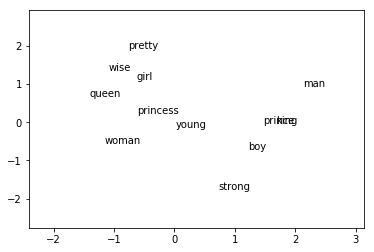

In [21]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (9,9)

plt.show()

시각화를 통해 비슷한 단어들이 서로 가까운 위치에 있는 것을 확인할 수 있습니다.  
예를 들면 prince, man, boy, king이 서로 비슷한 위치에 군집해있고,  
princess, girl, woman 역시 서로 비슷한 위치에 군집해 있는 것을 확인 가능합니다.  
단어의 의미론적 유사도를 가지고 있는 word2vec은 딥러닝을 활용한 자연어처리 분야에서 큰 발전을 이끌어나가고 있습니다.

# 참고자료
McCormick, C. (2016, April 19). Word2Vec Tutorial - The Skip-Gram Model.   
https://arxiv.org/pdf/1301.3781.pdf